# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 3
# Multiple Linear Regression, Subset Selection, Cross Validation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [6]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

# Forecasting Bike Sharing Usage

In this homework, we will focus on multiple linear regression and will explore techniques for subset selection. The specific task is to build a regression model for a bike share system that can predict the total number of bike rentals in a given day, based on attributes about the day. Such a demand forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city. The data for this problem was collected from the Capital Bikeshare program in Washington D.C. over two years.   

The data set is provided in the files `Bikeshare_train.csv` and `Bikeshare_test.csv`, as separate training and test sets. Each row in these files contains 10 attributes describing a day and its weather:
- season (1 = spring, 2 = summer, 3 = fall, 4 = winter)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp (temperature in Celsius)
- atemp (apparent temperature, or relative outdoor temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)

and the last column 'count' contains the response variable, i.e. total number of bike rentals on the day.


## Part (a): Data Exploration & Preprocessing

As a first step, identify important characteristics of the data using suitable visualizations when necessary. Some of the questions you may ask include (but are not limited to):

- How does the number of bike rentals vary between weekdays and weekends? 
- How about bike rentals on holidays?
- What effect does the season have on the bike rentals on a given day?
- Is the number of bike rentals lower than average when there is rain or snow?
- How does temperature effect bike rentals?
- Do any of the numeric attributes have a clear non-linear dependence with number of the bike rentals?



In [7]:
#your code here
Biketrain = pd.read_csv('Bikeshare_train.csv')
Biketest = pd.read_csv('Bikeshare_test.csv')
Biketrain.describe()


,Unnamed: 0,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000
mean,165.000000,2.561934,6.640483,0.033233,2.854985,0.670695,1.389728,17.018127,19.543807,63.385776,0.190833,4598.447130
std,95.695698,1.094726,3.353974,0.179515,2.048680,0.470672,0.546962,11.192515,9.930991,14.334789,0.078240,1935.319338
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,25.416700,0.022392,431.000000
25%,82.500000,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,7.500000,11.000000,52.702900,0.133083,3370.000000
50%,165.000000,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,18.000000,21.000000,63.291700,0.178479,4648.000000
75%,247.500000,4.000000,9.500000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.500000,0.235380,5981.000000
max,330.000000,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,38.000000,39.000000,97.250000,0.421642,8714.000000


- For Simplicity I wanted all my graphs in subplots next to each other so I could reference them easily, therefore I have used the subplot instance here

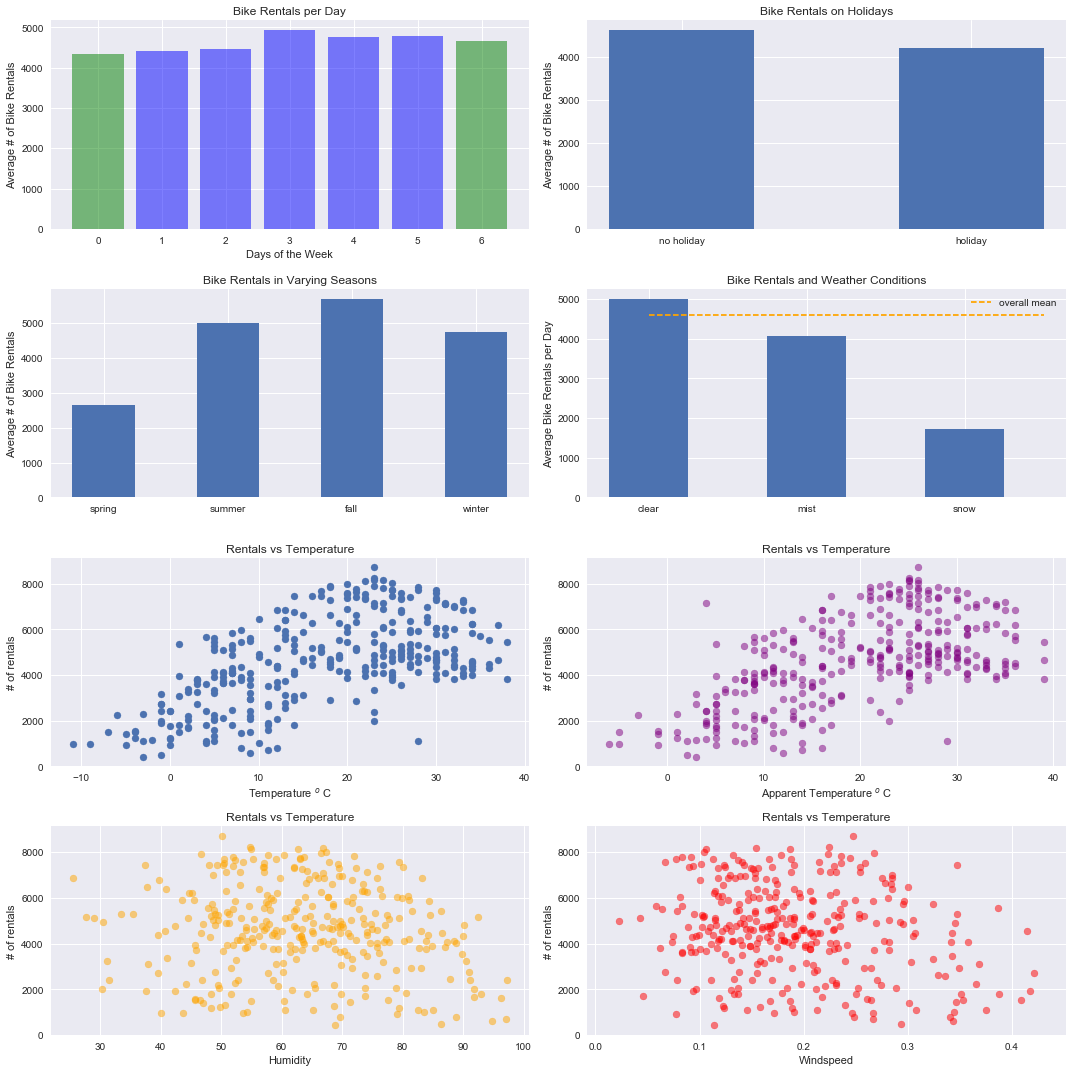

In [8]:
fig,ax = plt.subplots(4,2,figsize = (15,15))

xx = Biketrain.groupby('day_of_week')['count'].agg('mean')
ax[0,0].bar(xx.index,xx.values,color = ['g','b','b','b','b','b','g'],alpha = 0.5)
ax[0,0].set_ylabel('Average # of Bike Rentals')
ax[0,0].set_xlabel('Days of the Week')
ax[0,0].set_title('Bike Rentals per Day')

xx = Biketrain.groupby('holiday')['count'].agg('mean')
ax[0,1].bar([0,0.4],xx.values,width = 0.2)
ax[0,1].set_xticks([0,0.4])
ax[0,1].set_xticklabels(['no holiday','holiday'])
ax[0,1].set_ylabel('Average # of Bike Rentals')
ax[0,1].set_title('Bike Rentals on Holidays')

xx = Biketrain.groupby('season')['count'].agg('mean')
ax[1,0].bar([0,0.4,0.8,1.2],xx.values,width = 0.2)
ax[1,0].set_xticks([0,0.4,0.8,1.2]),
ax[1,0].set_xticklabels(['spring','summer','fall','winter'])
ax[1,0].set_ylabel('Average # of Bike Rentals')
ax[1,0].set_title('Bike Rentals in Varying Seasons')
xx = Biketrain.groupby('weather')['count'].agg('mean')

ax[1,1].bar([0,0.4,0.8],xx.values,width = 0.2)
ax[1,1].set_xticks([0,0.4,0.8])
ax[1,1].set_title('Bike Rentals and Weather Conditions')
ax[1,1].set_xticklabels(['clear','mist','snow','rain'])
ax[1,1].set_ylabel('Average Bike Rentals per Day')
ax[1,1].plot(np.linspace(0,1,100),4598*np.ones(100),linestyle ='dashed',color = 'orange',label = 'overall mean')
ax[1,1].legend()

ax[2,0].scatter(Biketrain['temp'],Biketrain['count'])
ax[2,0].set_ylabel('# of rentals')
ax[2,0].set_xlabel('Temperature $^o$ C')
ax[2,0].set_title('Rentals vs Temperature')

ax[2,1].scatter(Biketrain['atemp'],Biketrain['count'],c = 'purple',alpha = 0.5)
ax[2,1].set_ylabel('# of rentals')
ax[2,1].set_xlabel('Apparent Temperature $^o$ C')
ax[2,1].set_title('Rentals vs Temperature')

ax[3,0].scatter(Biketrain['humidity'],Biketrain['count'],c = 'orange',alpha = 0.5)
ax[3,0].set_ylabel('# of rentals')
ax[3,0].set_xlabel('Humidity')
ax[3,0].set_title('Rentals vs Temperature')

ax[3,1].scatter(Biketrain['windspeed'],Biketrain['count'],c = 'r',alpha = 0.5)
ax[3,1].set_ylabel('# of rentals')
ax[3,1].set_xlabel('Windspeed')
ax[3,1].set_title('Rentals vs Temperature')
fig.tight_layout()

Your Answer Here:


a) We can see from the top left figure that on wednesdays the average number of bikes rented out is the highest in the 2 years, while average bike rentals on weekends are slightly lower suggesting that many people are using bikes to travel to work during the week.

b) Average number of bike rentals when it isn't a holiday are higher suggesting that there is more use on average over non holiday days.

c) According to Nathaniel, the ordering of the seasons is wrong. Essentially we see that in fall we have the highest average rentals but this should be summer which makes sense.

d) In terms of weather, clear weather means more bike rentals than average as can be seen while misty and rainy days are not like that

e) we see rentals linearly correlated to temperature and atemperature which in some way is an alternative metric for season.

f) Humidity and Windspeed give no immediate visible correlation.

We next require you to pre-process the categorical and numerical attributes in the data set:

- Notice that this data set contains categorical attributes with two or more categories. **Why can't they be directly used as predictors?** Convert these categorical attributes into multiple binary attributes using one-hot encoding: in the place of every categorical attribute $x_j$ that has categories $1, \ldots, K_j$, introduce $K_j-1$ binary predictors $x_{j1}, \ldots, x_{j,K_j-1}$ where $x_{jk}$ is 1 whenever $x_j = k$ and 0 otherwise. 
** Why is it okay to not have a binary column for the $K_j$-th category? **

- Since the attributes are in different scales, it is a good practice to standardize the continuous predictors, i.e. to scale each continuous predictor to have zero mean and a standard deviation of 1. This can be done by applying the following transform to each continuous-valued predictor $j$:
$\hat{x}_{ij} = (x_{ij} - \bar{x}_j) / s_j$, where $\bar{x}_j$ and $s_j$ are the sample mean and sample standard deviation (SD) of predictor $j$ in the training set. We emphasize that the mean and SD values used for standardization must be estimated using only the training set observations, while the transform is applied to both the training and test sets. 
** Why shouldn't we include the test set observations in computing the mean and SD? **

- Provide a table of the summary statistics of the new attributes (`pd.describe()' function will help).

*Hint:* You may use the `pd.get_dummies` function to convert a categorical attribute in a data frame to one-hot encoding. This function creates $K$ binary columns for an attribute with $K$ categories. We suggest that you delete the last (or first) binary column generated by this function.

**Note:** We shall use the term "attribute" to refer to a categorical column in the data set, and the term "predictor" to refer to the individual binary columns resulting out of one-hot encoding.

- # Note: I split train and test for loops just for simplicity and clarity and to avoid confusion between variables

In [9]:
Xtrain = []

# Drop first column of dummy variables generated
for i in range(6):
    temp = pd.get_dummies(Biketrain.iloc[:,1+i],drop_first = True)
    pos = Biketrain.columns[1+i]
    #temp.drop(temp.columns[[-1,]],axis = 1,inplace = True)
    temp.columns = [str(pos)+'_'+str(int(col_name)) for col_name in temp.columns]
    Xtrain.append(temp)
    
means =[]
stdevs = []
for j in range(4):
    temp = Biketrain.iloc[:,7+j]
    mean = temp.mean()
    #means.append(mean)
    std = temp.std()
    #stdevs.append(std)
    Xtrain.append(((temp)-mean)/std)

Xtrain = pd.concat(Xtrain,axis = 1)
Xvar = pd.DataFrame.copy(Xtrain)

Xtrain.to_pickle('Xtrain')
Xtrain.describe()

,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_4,day_of_week_5,day_of_week_6,workingday_1,weather_2,weather_3,temp,atemp,humidity,windspeed
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,...,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,0.259819,0.265861,0.256798,0.066465,0.075529,0.078550,0.102719,0.072508,0.093656,0.081571,...,0.123867,0.145015,0.135952,0.670695,0.329305,0.030211,-6.976628e-17,-1.227618e-16,-7.808457e-16,1.543579e-15
std,0.439199,0.442459,0.437528,0.249471,0.264643,0.269442,0.304051,0.259719,0.291790,0.274124,...,0.329929,0.352649,0.343256,0.470672,0.470672,0.171428,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.503291e+00,-2.572131e+00,-2.648736e+00,-2.152869e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.504011e-01,-8.603176e-01,-7.452412e-01,-7.381149e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,8.772587e-02,1.466312e-01,-6.562743e-03,-1.579037e-01
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.024892e-01,7.508005e-01,7.055719e-01,5.693478e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.874634e+00,1.959139e+00,2.362380e+00,2.949989e+00


In [10]:
# first 6 columns should be dummied
# then next 4 should be standardized
Xtest = []
for i in range(6):
    temp = pd.get_dummies(Biketest.iloc[:,1+i],drop_first = True)
    pos = Biketest.columns[1+i]
    #temp.drop(temp.columns[[-1,]],axis = 1,inplace = True)
    temp.columns = [str(pos)+'_'+str(int(col_name)) for col_name in temp.columns]
    Xtest.append(temp)
for j in range(4):
    temp = (Biketest.iloc[:,7+j])
    # Taking the mean of test - Rahul said this was a good way of doing it!
    #mean = means[j]
    #std = stdevs[j]
    mean = temp.mean()
    std = temp.std()
    Xtest.append(((temp)-mean)/std)

Xtest = pd.concat(Xtest,axis = 1)
Xvartest = pd.DataFrame.copy(Xtest)

Xtest.to_pickle('Xtest')
Xtest.describe()

,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,day_of_week_4,day_of_week_5,day_of_week_6,workingday_1,weather_2,weather_3,temp,atemp,humidity,windspeed
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.00000,400.000000,400.00000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,0.245000,0.250000,0.232500,0.08750,0.092500,0.085000,0.070000,0.09000,0.077500,0.08750,...,0.157500,0.140000,0.150000,0.695000,0.345000,0.02750,-1.136244e-17,-2.824130e-17,2.276929e-15,1.106337e-15
std,0.430626,0.433555,0.422955,0.28292,0.290093,0.279231,0.255467,0.28654,0.267718,0.28292,...,0.364728,0.347422,0.357519,0.460984,0.475964,0.16374,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-2.086733e+00,-2.119826e+00,-4.397757e+00,-1.881065e+00
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-8.980743e-01,-8.862659e-01,-8.133533e-01,-7.176605e-01
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,-4.903218e-02,-3.226235e-02,-1.647755e-02,-9.165791e-02
75%,0.000000,0.250000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000,8.849141e-01,9.166304e-01,7.505049e-01,5.518796e-01
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.988669e+00,2.245080e+00,2.305789e+00,4.121656e+00


Your Answer Here:
    
- The categorical features cannot directly be used as predictors because the model will learn a beta to try and classify something into 1 of n categories. This beta may turn out to be an average if there are as many 1's as there are 2's as there are 3's for example and the response is constant. However, an average beta will likely handle some categories better than others or worse, handle none at all.

- It is therefore necessary to use one hot encoding to solve the problem and to ensure each category has its own beta. However, if we split a column with 4 seasons into 4 individual columns we will find collinearity between the first 3 and the 4th predictor. In essence 1-sum(1:3) gives us the 4'th column which is why it is ok and preferred to drop it otherwise our 4'th feature doesn't really add value to our model. In fact, by keeping this collinear term our model is likely to become sensitive to dimension reductions and beta estimates may have a large variance.

- We should not include the test set mean and standard deviation because we would leak information from the test set into our training model, thus reducing our ability to truly test 'out of sample' data, and reducing our overal predictive ability. Thus in our model we used mean of training on the training set and mean of test on the test set to standardize. This approach was endorsed by Rahul

## Part (b): Multiple Linear Regression

We are now ready to fit a linear regression model and analyze its coefficients and residuals.

- Fit a multiple linear regression model to the training set, and report its $R^2$ score on the test set.
- *Statistical significance*: Using a t-test, find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value<0.05). Based on the results of the test, answer the following questions:
    - Which among the predictors have a positive correlation with the number of bike rentals? 
    - Does the day of a week have a relationship with bike rentals? 
    - Does the month influence the bike rentals? 
    - What effect does a holiday have on  bike rentals? 
    - Is there a difference in the coefficients assigned to `temp` and `atemp`? Give an explanation for your observation.
- *Residual plot:* Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms?


In [15]:
# your code here
#X_train = pd.DataFrame.as_matrix(Xtrain)
y_train = Biketrain['count'].values
#X_test = pd.DataFrame.as_matrix(Xtest)
y_test = Biketest['count'].values
X_train = Xtrain
X_test = Xtest
# regression fit
X = sm.add_constant(X_train)
ols = sm.OLS(y_train,X).fit()
print('test R^2 on all predictors = %s' %r2_score(y_test,ols.predict(sm.add_constant(X_test))))
ols.summary()

test R^2 on all predictors = 0.257836291875


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     15.25
Date:                Sat, 07 Oct 2017   Prob (F-statistic):           6.56e-42
Time:                        10:25:28   Log-Likelihood:                -2832.1
No. Observations:                 331   AIC:                             5720.
Df Residuals:                     303   BIC:                             5827.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          3681.7765    433.655      8.490      0.000      2828.419  4535.134
season_2        898.8290    487.802      1.843      0.066       -61.079  1858.737
season_3       1032.8816    567.827      1.819      0.070       -84.503  2150.266
season_4       1226.1865    506.763      2.420      0.016       228.966  2223.407
month_2          88.9401    397.048      0.224      0.823      -692.381   870.262
month_3         239.1809    446.873      0.535      0.593      -640.188  1118.549
month_4         333.3491    675.444      0.494      0.622      -995.806  1662.504
month_5         -65.8125    726.311     -0.091      0.928     -1495.065  1363.440
month_6        -792.2629    749.803     -1.057      0.292     -2267.744   683.218
month_7       -1279.9870    816.047     -1.569      0.118     -2885.824   325.850
month_8        -776.4755    794.782     -0.977      0.329     -2340.467   787.516
month_9         405.1446    694.714      0.583      0.560      -961.931  1772.220
month_10        486.2509    651.713      0.746      0.456      -796.206  1768.708
month_11        112.6816    621.610      0.181      0.856     -1110.538  1335.902
month_12       -118.8358    505.353     -0.235      0.814     -1113.282   875.611
holiday_1      -284.3563    398.982     -0.713      0.477     -1069.483   500.770
day_of_week_1  -123.7515    170.981     -0.724      0.470      -460.212   212.709
day_of_week_2  -195.2859    203.703     -0.959      0.338      -596.137   205.565
day_of_week_3   170.5113    213.789      0.798      0.426      -250.187   591.210
day_of_week_4    61.2560    206.213      0.297      0.767      -344.536   467.048
day_of_week_5   111.0669    198.877      0.558      0.577      -280.288   502.422
day_of_week_6   465.1450    269.154      1.728      0.085       -64.504   994.794
workingday_1    308.1531    165.413      1.863      0.063       -17.351   633.657
weather_2       -16.5666    210.139     -0.079      0.937      -430.083   396.949
weather_3     -1581.9783    529.223     -2.989      0.003     -2623.396  -540.560
temp            925.7338    474.536      1.951      0.052        -8.070  1859.538
atemp           312.4341    429.987      0.727      0.468      -533.705  1158.573
humidity       -548.4929    113.200     -4.845      0.000      -771.251  -325.735
windspeed      -255.1226     80.766     -3.159      0.002      -414.057   -96.189
==============================================================================
Omnibus:                       28.947   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.753
Skew:                           0.054   Prob(JB):                      0.00762
Kurtosis:                       2.166   Cond. No.                     2.81e+15
================================================================

In [9]:
# Array of Indices with p values less than 0.05
collist = ['season4','weather3','humidity','windspeed']

In [10]:
collist

['season4', 'weather3', 'humidity', 'windspeed']

- From the list, only season 4 is positively correlated(has +ve $\beta$) from those with p values less than 0.05
- From the t test it seems that days doesn't affect bike rentals. 
- The month doesn't seem to affect rentals, or atleast the t test suggests this but season4 for example is a proxy for this.
- holidays is not statistically significant at this level.
- temp has a coeff of 925 and atemp has a coeff of 312.This might be due to their different significance levels but more importantly it could be due to their scaling, in that atemp standardized is on average 3 times larger than temp

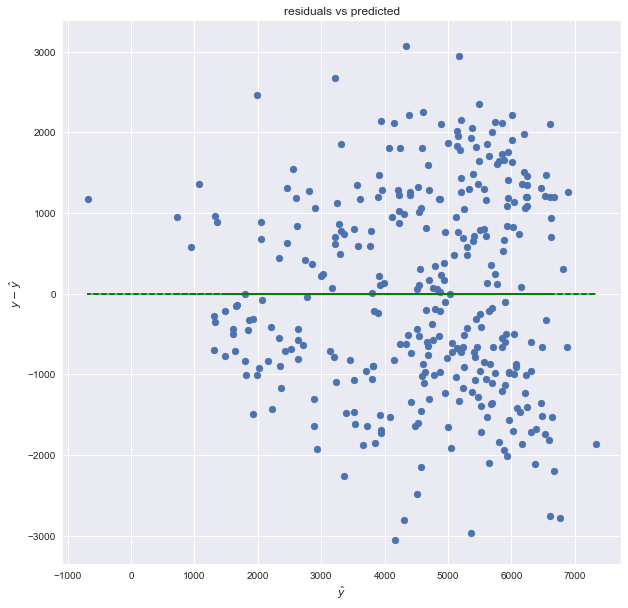

In [12]:
# residual plot
plt.figure(figsize = (10,10))
plt.scatter(ols.predict(X),y_train - ols.predict(X))
plt.plot(ols.predict(X),np.zeros(len(X)),linestyle = '--',c = 'green')
plt.xlabel('$\hat{y}$')
plt.ylabel('$y-\hat{y}$')
plt.title('residuals vs predicted')

- The plot suggests that as the predicted value goes up, the error goes up. This suggests that while our model is relatively good at assessing days when there are only a few bike rentals, it performs worse on days when bike rentals are high.

- Plot suggests that variance of error terms is increasing with higher estimates of y

## Part (c): Checking Collinearity

Does the data suffer from multi-collinearity? To answer this question, let us first analyze the correlation matrix for the data. Compute the (Pearson product-moment) correlation matrix for the predictor variables in the training set, and visualize the matrix using a heatmap. For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Are there predictors that fall into natural groups based on the correlation values? 

*Hint:* You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.

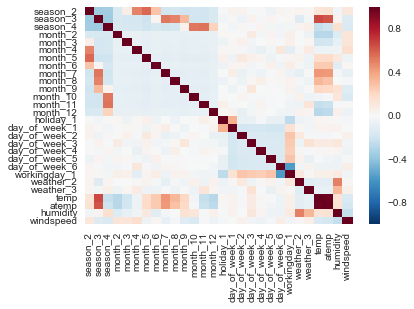

In [14]:
sns.heatmap(Xtrain.corr())

- We can see that terms with themselves are perfectly correlated as expected
- We can see that season_3 (which is listed as fall but actually should be summer as was discussed in piazza by Nathaniel) is correlated to temperature which makes intuitive sense.
- We can see month 7-9 also well correlated to season 3, month 4-6 also well correlated to season 2 and etc
- Negative correlation between temperature and season 1 makes sense since 1 is winter


## Part (d): Subset Selection

Apply either one of the following subset selection methods discussed in class to choose a minimal subset of predictors that are related to the response variable:
- Step-wise forward selection
- Step-wise backward selection

We require you to implement both these methods *from scratch*. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. Do these methods eliminate one or more of the redundant predictors (if any) identified in Part (c)? In each case, fit linear regression models using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Part (b) using all predictors?




In [15]:
colforward = Xvar.columns.values
colbest =[]
# step-wise forward selection!
def get_r2(Xtr,ytr):
    Xtr = sm.add_constant(Xtr)
    return sm.OLS(ytr,Xtr).fit().bic

# dummy of all features which we reduce after finding k best
models = []
for i in range(np.shape(X_train)[1]):
    if i == 0:
        score = []
        for j in range(len(colforward)):
            xx = Xtrain[colforward[j]].values
            score.append(get_r2(xx,y_train))
        colbest.append(colforward[np.argmin(score)])
        colforward = np.delete(colforward,np.argmin(score))        
    elif i != 0:
        score = []
        for j in range(len(colforward)):
            colnames = colbest + [colforward[j]]
            xx = Xtrain[colnames].values
            score.append(get_r2(xx,y_train))
        colbest.append(colforward[np.argmin(score)])
        colforward = np.delete(colforward,np.argmin(score))
                

In [30]:
bicscore = []
for i in range(len(colbest)):
    xx = Xtrain[colbest[0:i+1]].values
    xx = sm.add_constant(xx)
    rez = sm.OLS(y_train,xx).fit()
    bicscore.append(rez.bic)

xx = Xtrain[colbest[0:7]].values
linreg = LinearRegression(fit_intercept = True)
linreg.fit(xx,y_train)
pred = linreg.predict(Xtest[colbest[0:7]])

print('Number of features in best forward model = %s'  %(np.argmin(bicscore)+1))
print('Features are:%s'%(colbest[0:7]))
print('Test R^2 = %s'%r2_score(y_test,pred))

Number of features in best forward model = 7
Features are:['atemp', 'humidity', 'season_4', 'month_9', 'season_2', 'weather_3', 'windspeed']
Test R^2 = 0.28522827352


In [31]:
# Backward
colback = Xvar.columns.values
colworst = []

# step-wise forward selection!
def get_r2(Xtrain,ytrain):
    Xtrain = sm.add_constant(Xtrain)
    return sm.OLS(ytrain,Xtrain).fit().bic

# dummy of all features which we reduce after finding k best
for i in range(np.shape(X_train)[1]):
    score = []
    for j in range(len(colback)):
        n = np.delete(colback,j)
        xx = Xtrain[n].values
        score.append(get_r2(xx,y_train))
    colworst.append(colback[np.argmin(score)])
    colback = np.delete(colback,np.argmin(score))


In [32]:
# Compute BIC score for best i predictors
bicscore = []
for i in range(len(colworst)):
    xx = Xtrain[colworst[i:]].values
    xx = sm.add_constant(xx)
    rez = sm.OLS(y_train,xx).fit()
    bicscore.append(rez.bic)

# check r^2 of test set with best model from above
xx = Xtrain[colworst[18:]].values
linreg = LinearRegression(fit_intercept = True)
linreg.fit(xx,y_train)
pred = linreg.predict(Xtest[colworst[18:]])

print('# of features in best backward model = %s' % (28-np.argmin(bicscore)))
print('Features are:%s'%(colworst[18:]))
print('Test R^2 = %s'%r2_score(y_test,pred))

# of features in best backward model = 10
Features are:['weather_3', 'season_3', 'season_2', 'month_8', 'month_6', 'windspeed', 'month_7', 'season_4', 'humidity', 'temp']
Test R^2 = 0.279927743449


your answers here

- Many of the day of week predictors seemed redundant and have been dropped in the selection
- season 3 and temp were both strongly correlated to the response and so backward keeps both.
- The test R^2 of forward is better than the backward model.
- Both forward and backward indicate a better overall score on the test set than one with all the predictors

## Part (e): Cross Validation

- Perform a 10-fold cross-validation procedure to select between the 3 competing models you have so far: the model with the best BIC from Step-wise forward selection, the model with the best BIC from Step-wise backward selection (if it is different), and the model with all possible predictors.  Report the average $R^2$ across all 10 validation sets for each model and compare the results.  Why do you think this is the case?
- Fit each of the 3 models on the provided left out test set and calculate $R^2$.  Do the results agree with the cross-validation?  Why or why not?

In [22]:
# your code here
from sklearn.model_selection import cross_val_score
r2s = np.zeros((10,3))
r2s[:,0] = cross_val_score(LinearRegression(fit_intercept = True),Xtrain.values,y_train,cv=10)
r2s[:,1] = cross_val_score(LinearRegression(fit_intercept = True),Xtrain[colbest[0:7]].values,y_train,cv=10)
r2s[:,2] = cross_val_score(LinearRegression(fit_intercept = True),Xtrain[colworst[18:]].values,y_train,cv=10)



In [24]:
# average R^2 of cross val models
print('CV R^2 of all predictors =%s' %r2s[:,0].mean())
print('CV R^2 of forwardstep =%s' %r2s[:,1].mean())
print('CV R^2 of backwardstep =%s' %r2s[:,2].mean())

CV R^2 of all predictors =0.34257855094
CV R^2 of forwardstep =0.440268095121
CV R^2 of backwardstep =0.460332743533


In [33]:
print('Test R^2 forward = 0.28522827352')
print('Test R^2 backward = 0.279927743449')
print('test R^2 on all predictors = 0.257836291875')

Test R^2 forward = 0.28522827352
Test R^2 backward = 0.279927743449
test R^2 on all predictors = 0.257836291875


- By cross validating we find that the average cross validation score of the forward/backward model is higher than that with all the predictors. This indicates that we should pick the forward/backward model.

- The model that performs the best on the test set is indeed the forward model (even though CV suggests we should pick the backward model). This may be due to the fact that the backward model has more predictors so is suffering from some overfitting in comparison to the forward model. 